# GPT2 Exps summary

In [34]:
import os
import sys

from dataclasses import dataclass
from typing import Any

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from gollem.gpu_stats import get_gpu_flops
from gollem.models.gpt2.config import get_gpt2_model_config
from gollem.utils import get_base_dir_path

gpt2_model_cfg = get_gpt2_model_config("gpt2")
gpt2_model_fpt = gpt2_model_cfg.compute_flops().total / gpt2_model_cfg.n_ctx


gpt2_df = pd.DataFrame(
    columns=["exp_num", "name", "device", "dtype", "num_devices", "tps", "mem"],
    data=[
        # start
        [0, "CPU", "cpu", "float32", 1, 685, None],
        # harware optimizations
        [1, "MPS", "mps", "float32", 1, 1392, None],
        [2, "RTX3090", "RTX3090", "float32", 1, 11331, 3285],
        [3, "H100", "H100", "float32", 1, 27026, 4371],
        # software optimizations
        [4, "bfloat16", "H100", "bfloat16", 1, 42871, 3514],
        [5, "Flash Attention", "H100", "bfloat16", 1, 48154, 2655],
        [6, "Compile", "H100", "bfloat16", 1, 55271, 2448],
        [7, "Fused Adamw", "H100", "bfloat16", 1, 78750, 2463],
        [8, "Tensorcores", "H100", "bfloat16", 1, 79013, 2463],
        # batch optimizations
        [9, "Incr. batch size", "H100", "bfloat16", 1, 349179, 35457],
        # DDP
        [10, "DDP", "H100", "bfloat16", 8, 3_046_409, 41567],
    ],
)


def compute_mfu(row: pd.Series) -> Any:
    if row["device"] in ["cpu", "mps"]:
        return None
    gpu_flops = get_gpu_flops(row["device"], row["dtype"])
    tps_per_device = row["tps"] / row["num_devices"]
    return ((gpt2_model_fpt * tps_per_device) / gpu_flops) * 100


gpt2_df["mfu"] = gpt2_df.apply(compute_mfu, axis=1)
gpt2_df["speedup"] = gpt2_df["tps"] / gpt2_df[gpt2_df["exp_num"] == 0]["tps"].max()

gpt2_df


,exp_num,name,device,dtype,num_devices,tps,mem,mfu,speedup
0,0,CPU,cpu,float32,1,685,NaN,NaN,1.000000
1,1,MPS,mps,float32,1,1392,NaN,NaN,2.032117
2,2,RTX3090,RTX3090,float32,1,11331,3285.0,26.893449,16.541606
3,3,H100,H100,float32,1,27026,4371.0,34.465750,39.454015
4,4,bfloat16,H100,bfloat16,1,42871,3514.0,3.703805,62.585401
5,5,Flash Attention,H100,bfloat16,1,48154,2655.0,4.160225,70.297810
6,6,Compile,H100,bfloat16,1,55271,2448.0,4.775092,80.687591
7,7,Fused Adamw,H100,bfloat16,1,78750,2463.0,6.803541,114.963504
8,8,Tensorcores,H100,bfloat16,1,79013,2463.0,6.826263,115.347445
9,9,Incr. batch size,H100,bfloat16,1,349179,35457.0,30.167032,509.750365


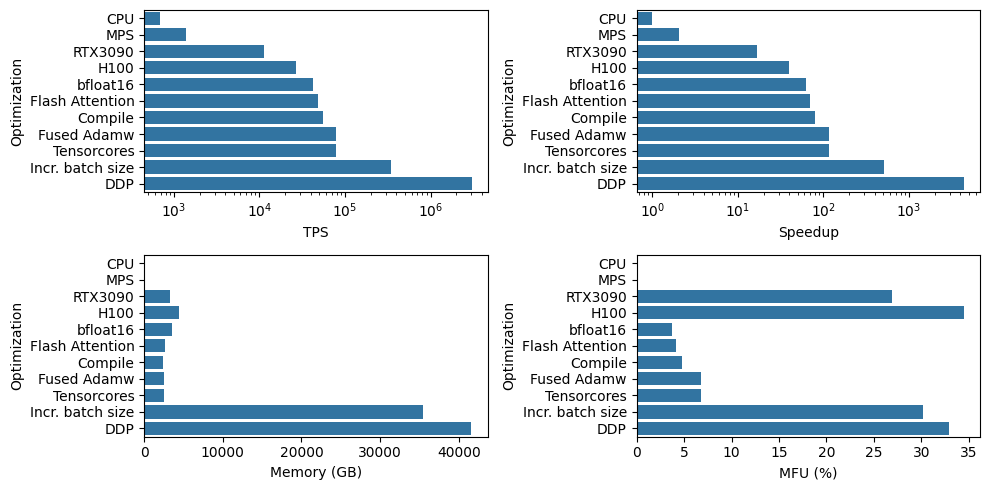

In [37]:
# Plot bar chart of tps, speedup, and mfu

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))

# gpt2_df = gpt2_df.sort_values(by="exp_num", ascending=False)
for ax, (col, use_log, label) in zip(
    axs.flatten(),
    [
        ("tps", True, "TPS"),
        ("speedup", True, "Speedup"),
        ("mem", False, "Memory (GB)"),
        ("mfu", False, "MFU (%)"),
    ],
):
    sns.barplot(x=col, y="name", data=gpt2_df, ax=ax)
    ax.set_xlabel(label)
    ax.set_ylabel("Optimization")
    if use_log:
        ax.set_xscale("log")


fig.tight_layout()
plt.show()
